# Microsoft Movie Maker Project
By Ferdinand Beaman
* Student pace: part time
* Scheduled project review date/time: May 3rd, 2023
* Instructor name: Mark Barbour
* Blog post URL: TBD


## Project Goal

This project is here to inform Microsoft of what factors will help their first (hypothetical) movie be a success. And by "success", I mean "generate the most profits".

### Data Source and Exploration
The data I used came primarily from [imdb.com](https://www.imdb.com/) and [the-numbers.com](https://www.the-numbers.com/). These websites have information about:
* titles, both domestic and international
* release dates
* cast and crew
* budgets
* Ticket sales, both domestic and international

In [1]:
#Importing the necessary libraries to find, analyze, and display the data.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
from glob import glob
from zipfile import ZipFile

In [2]:
#Grabbing the CSV data
csv_files = glob("./zippedData/*.csv.gz")

csv_files_dict = {}
for filename in csv_files:
        filename_cleaned = os.path.basename(filename).replace(
            ".csv", "").replace(".", "_")
        filename_df = pd.read_csv(filename, index_col=0)
        csv_files_dict[filename_cleaned] = filename_df

In [3]:
#Grabbing the data from imdb

file_name = "./ZippedData/im.db.zip"
with ZipFile(file_name, 'r') as zip:
    zip.printdir()
    zip.extractall()

#Extracting table names
con = sqlite3.connect("./im.db")
cur = con.cursor()

cur.execute("""SELECT name FROM sqlite_master  
  WHERE type='table';""")
cur.fetchall()

File Name                                             Modified             Size
im.db                                          2021-12-20 16:31:38    169443328


[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [4]:
#All the tables I might work from

#TheMovieDatabase
tmdb = csv_files_dict["tmdb_movies_gz"]

#The Numbers
tn = csv_files_dict["tn_movie_budgets_gz"]

#Box Office Mojo
bom = csv_files_dict["bom_movie_gross_gz"]

#And all the individual tables from IMDB
imdb_movie_basics = pd.DataFrame(data = 
                                 cur.execute("""SELECT * 
                                 FROM movie_basics"""))

imdb_akas = pd.DataFrame(data = 
                         cur.execute("""SELECT * 
                         FROM movie_akas"""))

imdb_known_for = pd.DataFrame(data = 
                              cur.execute("""SELECT * 
                              FROM known_for"""))

imdb_directors = pd.DataFrame(data = 
                              cur.execute("""SELECT * 
                              FROM directors"""))

imdb_writers = pd.DataFrame(data = 
                              cur.execute("""SELECT * 
                              FROM writers"""))

imdb_persons = pd.DataFrame(data = 
                              cur.execute("""SELECT * 
                              FROM persons"""))

Since my goal is to find what movies are profitable and not what movies are well-reviewed, I'm ignoring the ratings-related files.

# Merging all the data

Everything we need is spread out amongst a few different dataframes. So we're going to stick them all together and then cut out what we don't need. 

There are three general categories of information I want to look at: the finances, the genre, and who worked on it. Lastly, we should also stick with modern movies... whatever that means.


## Lining the numbers up

The data from "the-numbers" needs a little cleaning to turn it into something useful. But it has all the financial data that we're going to using as our measure of "success".

In [5]:
tn.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [6]:
#Making a dedicated "year" column
tn["year"] = tn["release_date"].map(lambda x: x[-4:])

#Turning budget and gross into integers from strings
tn["budget"] = tn["production_budget"].map(
    lambda x: x.replace("$", "")).map(lambda x: x.replace(
    ",","")).map(lambda x: int(x))

tn["world_gross"] = tn["worldwide_gross"].map(
    lambda x: x.replace("$", "")).map(lambda x: x.replace(
    ",","")).map(lambda x: int(x))

#Dropping unecessary columns
tn.drop(["production_budget","worldwide_gross"
       , "domestic_gross", "release_date"], 1, inplace = True)

#Dropping any duplicate entries.
tn.drop_duplicates(inplace = True)

Now to get the first number I really want: profits! (This will be the difference between worldwide gross and budget)

In [7]:
tn["profits"] = tn["world_gross"] - tn["budget"]
#And, let's just see what the most profitable movies of all time were
tn.sort_values("profits", ascending = False).head(15)

,movie,year,budget,world_gross,profits
id,,,,,
1,Avatar,2009,425000000,2776345279,2351345279
43,Titanic,1997,200000000,2208208395,2008208395
7,Avengers: Infinity War,2018,300000000,2048134200,1748134200
6,Star Wars Ep. VII: The Force Awakens,2015,306000000,2053311220,1747311220
34,Jurassic World,2015,215000000,1648854864,1433854864
67,Furious 7,2015,190000000,1518722794,1328722794
27,The Avengers,2012,225000000,1517935897,1292935897
61,Harry Potter and the Deathly Hallows: Part II,2011,125000000,1341693157,1216693157
42,Black Panther,2018,200000000,1348258224,1148258224


Awful lot of Marvel and other Disney products on there. Practically half of the top 15.

Now there's no easy way to parse how much of that has to do with Marvel's branding or how much of it has to do with Marvel's quality. But it's in the dataset nonetheless.


## Getting a sense of style

I bet that most people's first answer to "What kind of movie should you make?" is a genre. So lets get those analyzed.

How are the genres labeled?

In [8]:
pd.read_sql("""SELECT genres
            FROM movie_basics""", con)

,genres
0,"Action,Crime,Drama"
1,"Biography,Drama"
2,Drama
3,"Comedy,Drama"
4,"Comedy,Drama,Fantasy"
...,...
146139,Drama
146140,Documentary
146141,Comedy
146142,None


It turns out that each entry is a list, but each list has only one element which is just a *single string* with all of the genres written down all at once. Or it is NoneType object (like the penultimate entry above). They will each require attention to handle properly.

In [9]:
#Isolating the genre column from IMDB, turning the rows into a list of lists
genre_column = (pd.read_sql("""SELECT genres
                            FROM movie_basics""", con).values.tolist())
#Transforming that into a set
all_genres = []
for batch in genre_column:
        if batch[0]: #Skips over the "None" entries
            genres = batch[0].split(",") #Unpacking the genres for each movie
            for genre in genres:
                if genre in all_genres:
                    continue
                else:
                    all_genres.append(genre)
all_genres

['Action',
 'Crime',
 'Drama',
 'Biography',
 'Comedy',
 'Fantasy',
 'Horror',
 'Thriller',
 'Adventure',
 'Animation',
 'Documentary',
 'History',
 'Mystery',
 'Sci-Fi',
 'Romance',
 'Family',
 'War',
 'Music',
 'Sport',
 'Western',
 'Musical',
 'Adult',
 'News',
 'Talk-Show',
 'Reality-TV',
 'Game-Show',
 'Short']

We're going to have to make each genre into its own column if we're going to get anywhere.

In [45]:
#The "movie_basics" table will be one of our final three tables to merge.
movie_basics = pd.read_sql("""SELECT *
            FROM movie_basics""", con)

#Making genre columns, filling with 0s to start
for genre in all_genres:
    movie_basics[genre] = 0

#Filling in rows that have no genres
movie_basics["genres"].fillna(value = "?", inplace = True)

#Function to assign genre label
def is_genre(df,genre):
    df.loc[(df.genres.str.contains(genre)), genre]=1
    return df

#Looping through
for x in all_genres:
    is_genre(movie_basics,x)
    
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,Action,Crime,Drama,Biography,...,Music,Sport,Western,Musical,Adult,News,Talk-Show,Reality-TV,Game-Show,Short
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Mwah! Just to orient myself, let's see what the most common genres are.

In [11]:
movie_basics[all_genres].sum().sort_values(ascending = False)

Documentary    51640
Drama          49883
Comedy         25312
Thriller       11883
Horror         10805
Action         10335
Romance         9372
Biography       8722
Crime           6753
Adventure       6465
Family          6227
History         6225
Music           5624
Mystery         4659
Fantasy         3516
Sci-Fi          3365
Animation       2799
Sport           2234
News            1551
Musical         1430
War             1405
Western          467
Reality-TV        98
Talk-Show         50
Adult             25
Short             11
Game-Show          4
dtype: int64

Wow! There was no way that I would have guessed that documentaries would be king, but I understand in retrospect.

## Asking for Direction
In my experience, a director makes or breaks a movie as much as any actor, maybe even moreso.

In [12]:
#Making DF from the directors table
directors = pd.read_sql("""SELECT person_id, movie_id, primary_name
            FROM directors
            LEFT JOIN persons
            USING(person_id)
            """,con)

#There were duplicates, for some reason.
directors.drop_duplicates(inplace = True)
#And a couple Nas
directors.dropna(inplace = True)
directors.reset_index(inplace = True)
directors

,index,person_id,movie_id,primary_name
0,0,nm0899854,tt0285252,Tony Vitale
1,1,nm1940585,tt0462036,Bill Haley
2,2,nm0151540,tt0835418,Jay Chandrasekhar
3,4,nm0089502,tt0878654,Albert Pyun
4,5,nm2291498,tt0878654,Joe Baile
...,...,...,...,...
163528,291169,nm10122357,tt8999974,Daysi Burbano
163529,291170,nm6711477,tt9001390,Bernard Lessa
163530,291171,nm10123242,tt9001494,Tate Nova
163531,291172,nm10123248,tt9001494,Courtney Faye Powell


For fun, I decided to see who are the most common directors.

In [13]:
directors.value_counts("primary_name").head(10)

primary_name
Omer Pasha          62
Larry Rosen         53
Rajiv Chilaka       49
Stephan Düfel       48
Graeme Duane        45
Gérard Courant      44
Claudio Costa       42
Nayato Fio Nuala    41
Sergey A.           39
Dustin Ferguson     39
dtype: int64

Well that's odd, maybe they directed a lot of foreign films...
*Checks Google*
...Nope! Omer Pasha directs music videos.

I'll have to make sure my finalists are movie directors in particular.

Come to think of it, I'm surprised to not see Speilberg in the top 10. What does the database say?

In [14]:
directors.value_counts("primary_name")["Steven Spielberg"]

9

*NINE?* 
It was here that I had thought I did something very wrong. But, thankfully, it turns out that the IMDB data is only from 2010 forward.<br> Phew.

I suppose that's it for this step. Next, I'll join them all together before cutting out the smaller and older films.

# Finalizing the dataset

## Stitching it together
First, I think it would be easy to sew the director table onto "movie basics" since they share an obvious column: movie_id.

In [46]:
movies_directors = movie_basics.merge(directors, on = "movie_id",
                                      how = "left")
movies_directors.drop("index", axis = 1, inplace = True)
movies_directors

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,Action,Crime,Drama,Biography,...,Western,Musical,Adult,News,Talk-Show,Reality-TV,Game-Show,Short,person_id,primary_name
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",1,1,1,0,...,0,0,0,0,0,0,0,0,nm0712540,Harnam Singh Rawail
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",0,0,1,1,...,0,0,0,0,0,0,0,0,nm0002411,Mani Kaul
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,0,0,1,0,...,0,0,0,0,0,0,0,0,nm0000080,Orson Welles
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",0,0,1,0,...,0,0,0,0,0,0,0,0,nm0611531,Hrishikesh Mukherjee
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",0,0,1,0,...,0,0,0,0,0,0,0,0,nm0765384,Valeria Sarmiento
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169256,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary,0,0,0,0,...,0,0,0,0,0,0,0,0,nm9272491,Ana Célia de Oliveira
169257,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy,0,0,0,0,...,0,0,0,0,0,0,0,0,nm7764440,Kanchan Nayak
169258,tt9916730,6 Gunn,6 Gunn,2017,116.0,?,0,0,0,0,...,0,0,0,0,0,0,0,0,nm10538612,Kiran Gawade
169259,tt9916754,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,2013,NaN,Documentary,0,0,0,0,...,0,0,0,0,0,0,0,0,nm9272490,Angela Gurgel


In [16]:
#Now to combine the movies/directors with the finacnes from TheNumbers.
tn.rename(columns = {"movie": "primary_title"}, inplace = True)
big_data = tn.merge(movies_directors, on = "primary_title", how = "inner")
big_data.drop_duplicates(inplace=True)

#Oddly, "start year" and "year" columns disagree.
#And 'start year' is often a later year for some reason
big_data.drop(["start_year", "original_title", "runtime_minutes"], 
              inplace = True, axis = 1)
big_data

,primary_title,year,budget,world_gross,profits,movie_id,genres,Action,Crime,Drama,...,Western,Musical,Adult,News,Talk-Show,Reality-TV,Game-Show,Short,person_id,primary_name
0,Avatar,2009,425000000,2776345279,2351345279,tt1775309,Horror,0,0,0,...,0,0,0,0,0,0,0,0,nm3786927,Atsushi Wada
1,Pirates of the Caribbean: On Stranger Tides,2011,410600000,1045663875,635063875,tt1298650,"Action,Adventure,Fantasy",1,0,0,...,0,0,0,0,0,0,0,0,nm0551128,Rob Marshall
2,Dark Phoenix,2019,350000000,149762350,-200237650,tt6565702,"Action,Adventure,Sci-Fi",1,0,0,...,0,0,0,0,0,0,0,0,nm1334526,Simon Kinberg
3,Avengers: Age of Ultron,2015,330600000,1403013963,1072413963,tt2395427,"Action,Adventure,Sci-Fi",1,0,0,...,0,0,0,0,0,0,0,0,nm0923736,Joss Whedon
4,Avengers: Infinity War,2018,300000000,2048134200,1748134200,tt4154756,"Action,Adventure,Sci-Fi",1,0,0,...,0,0,0,0,0,0,0,0,nm0751577,Anthony Russo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4258,Bang,1996,10000,527,-9473,tt6616538,?,0,0,0,...,0,0,0,0,0,0,0,0,nm4419546,Uwe Schwarzwalder
4259,Newlyweds,2012,9000,4584,-4416,tt1880418,"Comedy,Drama",0,0,1,...,0,0,0,0,0,0,0,0,nm0122653,Edward Burns
4260,Red 11,2018,7000,0,-7000,tt7837402,"Horror,Sci-Fi,Thriller",0,0,0,...,0,0,0,0,0,0,0,0,nm0001675,Robert Rodriguez
4261,A Plague So Pleasant,2015,1400,0,-1400,tt2107644,"Drama,Horror,Thriller",0,0,1,...,0,0,0,0,0,0,0,0,nm4766951,Benjamin Roberds


## Cutting the chaff
All of the movies I want are going to be less than 10 years old. However, I'm going to have to remove all the entries from 2020 and 2021 due to the pandemic.

Pre-pandemic, the average movie released in theaters made 12,487,209 in the US, so I think it'll be a fair starting point to say that in order for a movie to be "relevant" to my project, it has to have made over half of that.

In [17]:
#For some reason the year entries were strings.
big_data.year = big_data.year.astype(int)

#Limiting to relevant times and finances
trim_data = big_data[(big_data["year"] > 2013) & (big_data["year"] < 2020) &
                     (big_data["world_gross"] > 6000000)]

trim_data

,primary_title,year,budget,world_gross,profits,movie_id,genres,Action,Crime,Drama,...,Western,Musical,Adult,News,Talk-Show,Reality-TV,Game-Show,Short,person_id,primary_name
2,Dark Phoenix,2019,350000000,149762350,-200237650,tt6565702,"Action,Adventure,Sci-Fi",1,0,0,...,0,0,0,0,0,0,0,0,nm1334526,Simon Kinberg
3,Avengers: Age of Ultron,2015,330600000,1403013963,1072413963,tt2395427,"Action,Adventure,Sci-Fi",1,0,0,...,0,0,0,0,0,0,0,0,nm0923736,Joss Whedon
4,Avengers: Infinity War,2018,300000000,2048134200,1748134200,tt4154756,"Action,Adventure,Sci-Fi",1,0,0,...,0,0,0,0,0,0,0,0,nm0751577,Anthony Russo
5,Avengers: Infinity War,2018,300000000,2048134200,1748134200,tt4154756,"Action,Adventure,Sci-Fi",1,0,0,...,0,0,0,0,0,0,0,0,nm0751648,Joe Russo
6,Justice League,2017,300000000,655945209,355945209,tt0974015,"Action,Adventure,Fantasy",1,0,0,...,0,0,0,0,0,0,0,0,nm0811583,Zack Snyder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3874,I Am Not Your Negro,2017,1000000,9617402,8617402,tt5804038,Documentary,0,0,0,...,0,0,0,0,0,0,0,0,nm0669704,Raoul Peck
3944,Lowriders,2017,916000,6188421,5272421,tt1366338,"Adventure,Crime,Drama",0,1,1,...,0,0,0,0,0,0,0,0,nm1662693,Ricardo de Montreuil
3947,Meet the Blacks,2016,900000,9097072,8197072,tt4191580,"Comedy,Horror",0,0,0,...,0,0,0,0,0,0,0,0,nm1938064,Deon Taylor
4191,The Gallows,2015,100000,41656474,41556474,tt2309260,"Horror,Mystery,Thriller",0,0,0,...,0,0,0,0,0,0,0,0,nm4000389,Travis Cluff


There are actually a lot of duplicates in this dataset. Why? Because movies with multiple directors are showing up as multiple entries.

I can foresee this being useful, so we'll keep this dataset with multiple directors as well as one where the duplications are cut out.

In [18]:
trim_no_d = trim_data.drop_duplicates(subset = ["year", "primary_title"])
trim_no_d

,primary_title,year,budget,world_gross,profits,movie_id,genres,Action,Crime,Drama,...,Western,Musical,Adult,News,Talk-Show,Reality-TV,Game-Show,Short,person_id,primary_name
2,Dark Phoenix,2019,350000000,149762350,-200237650,tt6565702,"Action,Adventure,Sci-Fi",1,0,0,...,0,0,0,0,0,0,0,0,nm1334526,Simon Kinberg
3,Avengers: Age of Ultron,2015,330600000,1403013963,1072413963,tt2395427,"Action,Adventure,Sci-Fi",1,0,0,...,0,0,0,0,0,0,0,0,nm0923736,Joss Whedon
4,Avengers: Infinity War,2018,300000000,2048134200,1748134200,tt4154756,"Action,Adventure,Sci-Fi",1,0,0,...,0,0,0,0,0,0,0,0,nm0751577,Anthony Russo
6,Justice League,2017,300000000,655945209,355945209,tt0974015,"Action,Adventure,Fantasy",1,0,0,...,0,0,0,0,0,0,0,0,nm0811583,Zack Snyder
7,Spectre,2015,300000000,879620923,579620923,tt2379713,"Action,Adventure,Thriller",1,0,0,...,0,0,0,0,0,0,0,0,nm0005222,Sam Mendes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3873,The Green Inferno,2015,1000000,12931420,11931420,tt2403021,"Adventure,Horror",0,0,0,...,0,0,0,0,0,0,0,0,nm0744834,Eli Roth
3874,I Am Not Your Negro,2017,1000000,9617402,8617402,tt5804038,Documentary,0,0,0,...,0,0,0,0,0,0,0,0,nm0669704,Raoul Peck
3944,Lowriders,2017,916000,6188421,5272421,tt1366338,"Adventure,Crime,Drama",0,1,1,...,0,0,0,0,0,0,0,0,nm1662693,Ricardo de Montreuil
3947,Meet the Blacks,2016,900000,9097072,8197072,tt4191580,"Comedy,Horror",0,0,0,...,0,0,0,0,0,0,0,0,nm1938064,Deon Taylor


In [19]:
#One last thing to check.
#trim_no_d.primary_name.value_counts()["Omer Pasha"]

Good.

# Measurements

## Picking the Medium
This part should be straightforward. Animation or Live Action?

In [20]:
#Getting the mean and median profits for animated and live action movies. 
live_mean_profits = trim_no_d[trim_no_d["Animation"] == 0]["profits"].mean()
ani_mean_profits = trim_no_d[trim_no_d["Animation"] == 1]["profits"].mean()

live_median_profits = trim_no_d[trim_no_d["Animation"] == 0
                               ]["profits"].median()
ani_median_profits = trim_no_d[trim_no_d["Animation"] == 1
                              ]["profits"].median()

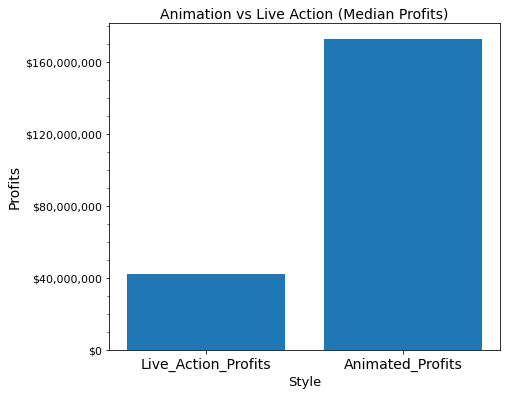

In [50]:
from matplotlib import ticker

#Preparing the formatting of my graphs
plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=11)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

fig, ax = plt.subplots(figsize=(7, 6))

plt.xlabel("Style", fontsize=13)
plt.ylabel("Profits", fontsize=14)
plt.title("Animation vs Live Action (Median Profits)", fontsize=14)

#Formatting the y-axis to be in dollars
ax.yaxis.set_major_locator(ticker.MultipleLocator(40000000.00))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10000000))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

ax = plt.bar(["Live_Action_Profits", "Animated_Profits"], 
        [live_median_profits, ani_median_profits])

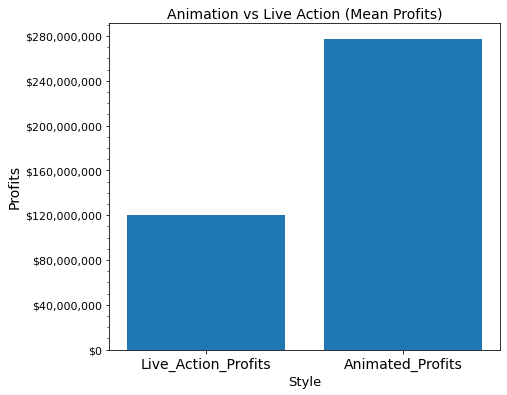

In [49]:
fig, ax = plt.subplots(figsize=(7, 6))

plt.xlabel("Style", fontsize=13)
plt.ylabel("Profits", fontsize=14)
plt.title("Animation vs Live Action (Mean Profits)", fontsize=14)

ax.yaxis.set_major_locator(ticker.MultipleLocator(40000000.00))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10000000))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

ax = plt.bar(["Live_Action_Profits", "Animated_Profits"], 
        [live_mean_profits, ani_mean_profits])

Well that's not even close! Animated movies are almost three times as profitable by mean, and nearly *quintuple* be median! One suggestion down, two to go.

Just how common are animated movies, anyway?

In [24]:
print("There are", len(trim_no_d[trim_no_d["Animation"] == 1]),
      "animated movies")
print("There are", len(trim_no_d[trim_no_d["Animation"] == 0]),
      "live action movies")
print("That's",(len(trim_no_d[trim_no_d["Animation"] == 1]))/(
    len(trim_no_d[trim_no_d["Animation"] == 1])+
    len(trim_no_d[trim_no_d["Animation"] == 0])), "percent")

There are 56 animated movies
There are 618 live action movies
That's 0.0830860534124629 percent


Okay, so that's a fair enough sample.

## Picking the Director

I'll get a look at the most profitable directors by both mean and median, then choose from among those the ones with the largest catalogs.

In [59]:
#Profits Mean, top 15
trim_data.groupby("primary_name").mean().sort_values(
    "profits", ascending = False).head(15)

,year,budget,world_gross,profits,Action,Crime,Drama,Biography,Comedy,Fantasy,...,Music,Sport,Western,Musical,Adult,News,Talk-Show,Reality-TV,Game-Show,Short
primary_name,,,,,,,,,,,,,,,,,,,,,
Colin Trevorrow,2015.0,215000000.0,1.648855e+09,1.433855e+09,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
James Wan,2016.5,175000000.0,1.332809e+09,1.157809e+09,1.0,0.5,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Christophe Gans,2017.0,160000000.0,1.259200e+09,1.099200e+09,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Marilyn Barnes,2017.0,160000000.0,1.259200e+09,1.099200e+09,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bill Condon,2017.0,160000000.0,1.259200e+09,1.099200e+09,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Zane Burden,2017.0,160000000.0,1.259200e+09,1.099200e+09,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Joss Whedon,2015.0,330600000.0,1.403014e+09,1.072414e+09,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Joe Russo,2016.0,240000000.0,1.300869e+09,1.060869e+09,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anthony Russo,2016.0,240000000.0,1.300869e+09,1.060869e+09,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
#Profits Median
trim_data.groupby("primary_name").median().sort_values(
    "profits", ascending = False).head(15)

,year,budget,world_gross,profits,Action,Crime,Drama,Biography,Comedy,Fantasy,...,Music,Sport,Western,Musical,Adult,News,Talk-Show,Reality-TV,Game-Show,Short
primary_name,,,,,,,,,,,,,,,,,,,,,
Colin Trevorrow,2015.0,215000000.0,1.648855e+09,1.433855e+09,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
James Wan,2016.5,175000000.0,1.332809e+09,1.157809e+09,1.0,0.5,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Marilyn Barnes,2017.0,160000000.0,1.259200e+09,1.099200e+09,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Christophe Gans,2017.0,160000000.0,1.259200e+09,1.099200e+09,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zane Burden,2017.0,160000000.0,1.259200e+09,1.099200e+09,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bill Condon,2017.0,160000000.0,1.259200e+09,1.099200e+09,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Joss Whedon,2015.0,330600000.0,1.403014e+09,1.072414e+09,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pierre Coffin,2016.0,74500000.0,1.097532e+09,1.023032e+09,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Kyle Balda,2016.0,74500000.0,1.097532e+09,1.023032e+09,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Clearly there's a bunch of overlap, and I am going to take just the directors whose names appear in both lists.

In [27]:
#Isolating just the top fifteen directors by each metric

top_median_directors = trim_data.groupby("primary_name").median().sort_values(
    "profits", ascending = False).head(15).index

top_mean_directors = trim_data.groupby("primary_name").mean().sort_values(
    "profits", ascending = False).head(15).index

In [28]:
#Creating the set of directors from both groups
top_directors = [name for name in top_median_directors 
                 if name in top_mean_directors]
top_directors

['Colin Trevorrow',
 'James Wan',
 'Marilyn Barnes',
 'Christophe Gans',
 'Zane Burden',
 'Bill Condon',
 'Joss Whedon',
 'Pierre Coffin',
 'Kyle Balda',
 'Eric Guillon',
 'Anna Boden',
 'Ryan Fleck',
 'Joe Russo',
 'Anthony Russo',
 'Jared Bush']

In [29]:
len(top_directors)

15

Everyone was in both lists. Unexpected. That probably means a lot of people only have 1 qualified movie to their name.

In [55]:
#making dfs that are grouped by mean and median
interim_mean = trim_data.groupby("primary_name").mean()
interim_median = trim_data.groupby("primary_name").median()

#selecting only the top 15 directors
top_director_interim_mean = interim_mean[
    interim_mean.index.isin(top_directors)]
top_director_interim_median = interim_median[
    interim_median.index.isin(top_directors)]

#sorting and isolating the profits column
d_means = top_director_interim_mean.sort_values(
    "profits", ascending = False)["profits"]
d_medians = top_director_interim_median.sort_values(
    "profits", ascending = False)["profits"]

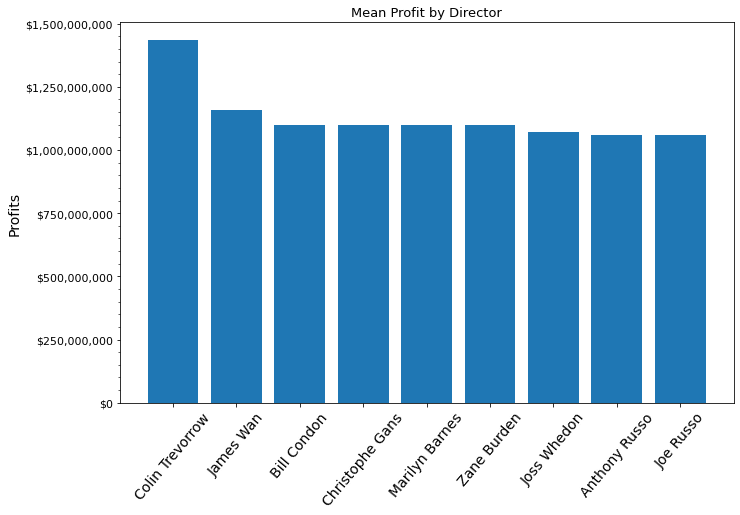

In [56]:
#Graphing the best of those results
fig, ax = plt.subplots(nrows =1, figsize = (11,7))

plt.ylabel("Profits", fontsize=14)

ax.yaxis.set_major_locator(ticker.MultipleLocator(250000000))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50000000))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

ax.bar(d_means.head(9).index, d_means.head(9))

ax.set_title("Mean Profit by Director", fontsize = 13)

ax.tick_params(axis = "x", labelrotation = 50)

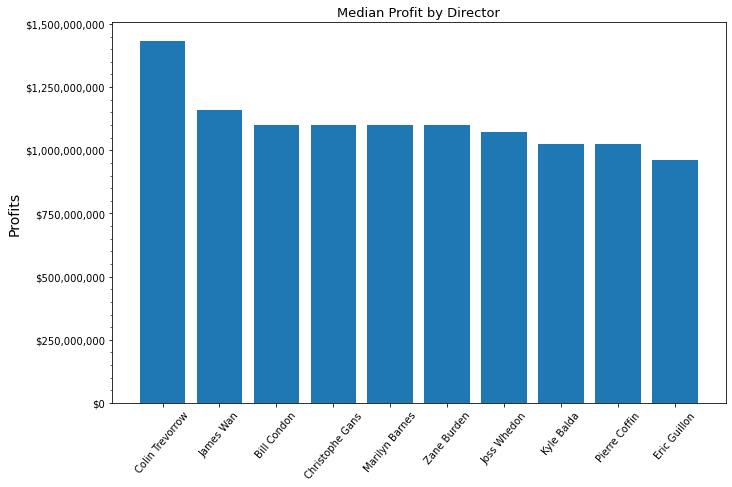

In [34]:
#Graphing those
fig, ax = plt.subplots(nrows =1, figsize = (11,7))

plt.ylabel("Profits", fontsize=14)

ax.yaxis.set_major_locator(ticker.MultipleLocator(250000000))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50000000))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

ax.bar(d_medians.head(10).index, d_medians.head(10))

ax.set_title("Median Profit by Director", fontsize = 13)

ax.tick_params(axis = "x", labelrotation = 50)

There really doesn't seem to be that big of a difference the further down the list we go. Surprisingly, the Russos (of Avengers: Endgame fame) fall out of the top 10 using the median.

How many movies these directors have made?

In [35]:
for name in top_directors:
    print(name, trim_data.primary_name.tolist().count(name))

Colin Trevorrow 1
James Wan 2
Marilyn Barnes 1
Christophe Gans 1
Zane Burden 1
Bill Condon 1
Joss Whedon 1
Pierre Coffin 2
Kyle Balda 2
Eric Guillon 1
Anna Boden 1
Ryan Fleck 1
Joe Russo 3
Anthony Russo 3
Jared Bush 1


Ah, so the reason why the median scores are what they are is because so many of these filmmakers have only one qualifying flick. Even with this many candidates, only the Russos stand out with three relevant movies in the last 10 years. Even though they fell out of the top 10 by median, they were still able to even qualify for this list in the first place despite their second and third place movies being less impressive.

As for the other directors who had multiple films that qualified:<br>
James Wan directed The Conjuring and Aquaman<br>
Kyle Balda directed two of the correctly-maligned Minions movies<br>
and Pierre Coffin... also directed two Minions movies.

Colin Treverrow was the leader on both lists with one movie. Luckily for us, that film *was* both an Adventure and Sci-Fi movie, making him a very defensible choice.

All in all, I'd still give it to the Russo Brothers, because they've done it more consistently. But it's probably debatable. It may be impossible to know how much of their success just has to do with the momentum Marvel supplies just by brand recognition.

## Picking the genre
I'm going to make a dataframe that's just made up of the profits (mean and median) for each genre.

In [36]:
#Preparing lists for my DF's columns
g_net_mean = []
g_net_median = []
g_count = []
#Filling those lists
all_genres.remove("Animation")
for genre in all_genres:
        g_net_mean.append(trim_no_d[trim_no_d[genre] == 1]["profits"].mean())
        g_net_median.append(
            trim_no_d[trim_no_d[genre] == 1]["profits"].median())
        g_count.append(len(trim_no_d[trim_no_d[genre] ==1]))

In [37]:
#Birthing the DataFrame
df_genres = pd.DataFrame()
df_genres["genre"] = all_genres
df_genres["count"] = g_count
df_genres["net_mean"] = g_net_mean
df_genres["net_median"] = g_net_median
df_genres.head()

,genre,count,net_mean,net_median
0,Action,210,2.292047e+08,113850443.5
1,Crime,97,6.972518e+07,26119388.0
2,Drama,315,6.515977e+07,23166033.0
3,Biography,86,6.037877e+07,19395340.5
4,Comedy,213,1.283210e+08,66511453.0


Now we isolate the sorted data for the profit columns.

In [38]:
g_means = df_genres.sort_values("net_mean", ascending = False).head(10)
g_medians = df_genres.sort_values("net_median", ascending = False).head(10)

In [39]:
g_means

,genre,count,net_mean,net_median
19,Musical,2,3.711085e+08,371108451.5
12,Sci-Fi,68,3.185443e+08,174183783.0
8,Adventure,191,2.679463e+08,150802233.0
0,Action,210,2.292047e+08,113850443.5
5,Fantasy,58,1.827135e+08,52140219.5
14,Family,35,1.563202e+08,60838736.0
16,Music,21,1.508239e+08,42160680.0
4,Comedy,213,1.283210e+08,66511453.0
7,Thriller,95,1.262089e+08,58220952.0
13,Romance,67,8.227228e+07,41540205.0


In [40]:
g_medians

,genre,count,net_mean,net_median
19,Musical,2,3.711085e+08,371108451.5
12,Sci-Fi,68,3.185443e+08,174183783.0
8,Adventure,191,2.679463e+08,150802233.0
0,Action,210,2.292047e+08,113850443.5
4,Comedy,213,1.283210e+08,66511453.0
14,Family,35,1.563202e+08,60838736.0
7,Thriller,95,1.262089e+08,58220952.0
5,Fantasy,58,1.827135e+08,52140219.5
16,Music,21,1.508239e+08,42160680.0
11,Mystery,59,7.145673e+07,41723644.0


Musicals take the gold medal?
Well, with only 2 representatives, I think it's fair to say that it's not exactly a tried and true formula for success. 

So, we'll take a closer look at the silver and bronze finalists instead: Sci-Fi and Adventure.

We can first make sure that outliers aren't driving the data, and we can also see if these genres are buoyed by data from the early 2010s.

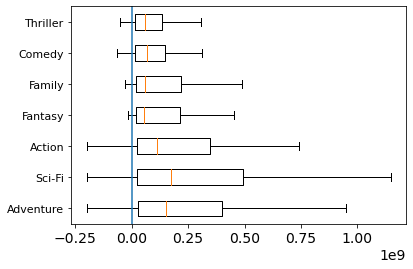

In [58]:
#Making a box blot of just the top genres
genre_cols = ["Adventure", "Sci-Fi", "Action",
              "Fantasy", "Family", "Comedy", "Thriller"]
boxplot_boxes = []
for genre in genre_cols:
    boxplot_boxes.append(trim_no_d[trim_no_d[genre] == 1]["profits"])
plt.boxplot(boxplot_boxes, vert = False, showfliers = False, labels =
            genre_cols)
plt.axvline();

While a little over 20% of our sample of Sci-Fi and Adventure movies lose money, it seems like many of the genres share this fate. And this boxplot has its outliers filtered out, so the big blockbusters are not solely responsible for these two pulling ahead.

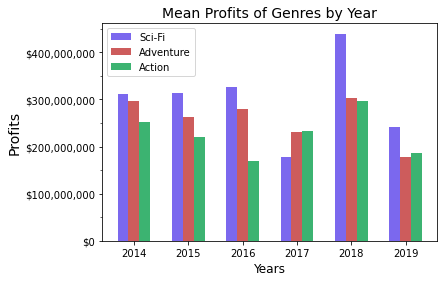

In [42]:
#Grouped bar graph, using Action as the control
fig, ax = plt.subplots()

ax.yaxis.set_major_locator(ticker.MultipleLocator(100000000))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50000000))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

x = np.arange(6)
y1 = trim_no_d[(trim_no_d["Sci-Fi"] == 1)].groupby('year').mean()["profits"]
y2 = trim_no_d[(trim_no_d["Adventure"] == 1)].groupby(
    'year').mean()["profits"]
y3 = trim_no_d[(trim_no_d["Action"] == 1)].groupby('year').mean()["profits"]
width = 0.2
  
plt.bar(x-0.2, y1, width, color='mediumslateblue')
plt.bar(x, y2, width, color='indianred')
plt.bar(x+0.2, y3, width, color='mediumseagreen')
plt.xticks(x, [2014, 2015, 2016, 2017, 2018, 2019])
plt.xlabel("Years", fontsize = 12)
plt.ylabel("Profits", fontsize = 14)
plt.legend(["Sci-Fi", "Adventure", "Action"])
plt.title("Mean Profits of Genres by Year", fontsize = 14)
plt.show()

In [43]:
#Why check by eye when we have math?
#Getting the Correlation Coefficient
np.corrcoef(y1, [2014, 2015, 2016, 2017, 2018, 2019])

array([[ 1.      , -0.076395],
       [-0.076395,  1.      ]])

Seems good to me. Let's just graph the overall means and medians now.

<BarContainer object of 10 artists>

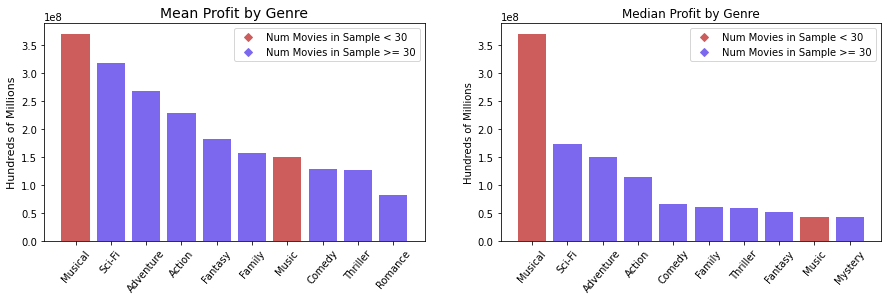

In [44]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 4))

#ax1.yaxis.set_major_locator(ticker.MultipleLocator(500000000))
#ax1.yaxis.set_minor_locator(ticker.MultipleLocator(250000000))
#ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

#ax2.yaxis.set_major_locator(ticker.MultipleLocator(500000000))
#ax2.yaxis.set_minor_locator(ticker.MultipleLocator(250000000))
#ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

#The bars will be colored based on whether the sample is high or low
colors1 = []
colors2 = []

for n in g_means["count"]:
    if n >= 30:
        colors1.append("mediumslateblue") #blue if 30 or higher
    else:
        colors1.append("indianred") #red if less than 30
        
for n in g_medians["count"]:
    if n >= 30:
        colors2.append("mediumslateblue")
    else:
        colors2.append("indianred")

genre_mean = g_means["net_mean"]
genre_median = g_medians["net_median"]

ax1.set_ylabel("Hundreds of Millions", fontsize = 11)
ax2.set_ylabel("Hundreds of Millions")

ax1.set_title("Mean Profit by Genre", fontsize = 14)
ax2.set_title("Median Profit by Genre")

ax1.tick_params(axis = "x", labelrotation = 50)
ax2.tick_params(axis = "x", labelrotation = 50)

import matplotlib.lines as mlines
low = mlines.Line2D([], [], color='indianred', 
                      marker='D', ls='', label='Num Movies in Sample < 30')
high = mlines.Line2D([], [], color='mediumslateblue', 
                     marker='D', ls='', label='Num Movies in Sample >= 30')

ax1.legend(handles=[low, high])
ax2.legend(handles=[low, high])

ax1.bar(g_means["genre"], genre_mean, color = colors1)
ax2.bar(g_medians["genre"], genre_median, color = colors2)

# So what do we conclude?
Putting it all together, I'm actually very pleased with the results.

Action and comedy are "ok", but I think that it would be wise to separate this project from a Marvel style movie. I'd suggest focusing on the two core genres to further make this film distinct from the competition.

So Microsoft could set itself apart with an *Animated Sci-Fi Adventure directed by the Russo Brothers*, perhaps with a more serious edge. If they turn it down, get Colin Treverrow. Failing that, James Wan will do.

I'd watch that.